In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-signs

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
 
 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.
signnames.csv  test.p  train.p	valid.p


In [2]:
np.random.seed(0)

In [3]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
# Spliting out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [5]:
assert(X_train.shape[0] == y_train.shape[0]), "Num of data and label are not equal"
assert(X_train.shape[1:] == (32,32,3)), "Dim should be 32 x 32 x 3"
assert(X_val.shape[0] == y_val.shape[0]), "Num of data and label are not equal"
assert(X_val.shape[1:] == (32,32,3)), "Dim should be 32 x 32 x 3"
assert(X_test.shape[0] == y_test.shape[0]), "Num of data and label are not equal"
assert(X_test.shape[1:] == (32,32,3)), "Dim should be 32 x 32 x 3"

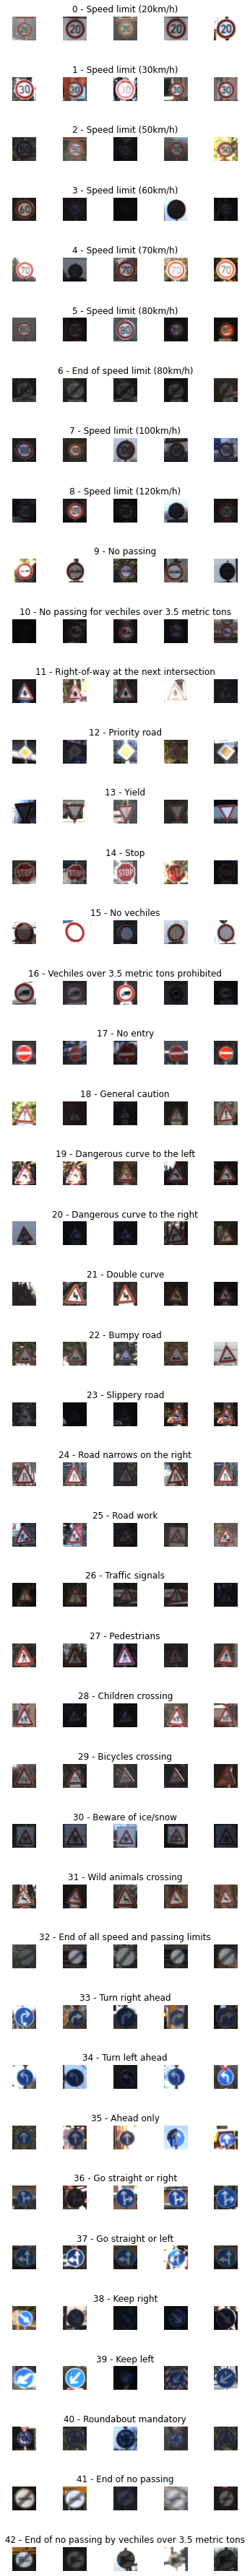

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
 
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


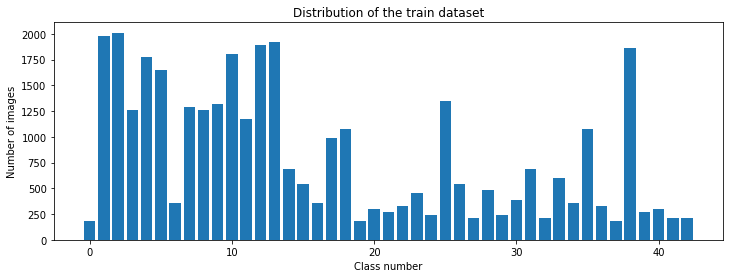

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


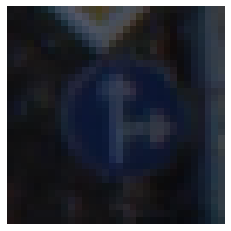

In [9]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


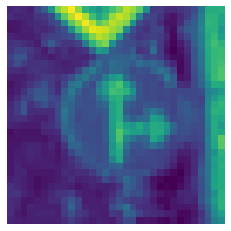

In [10]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [11]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


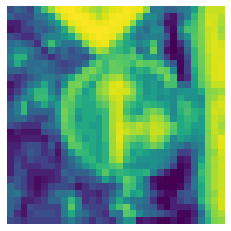

In [12]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [13]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


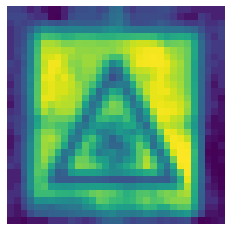

In [14]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [15]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

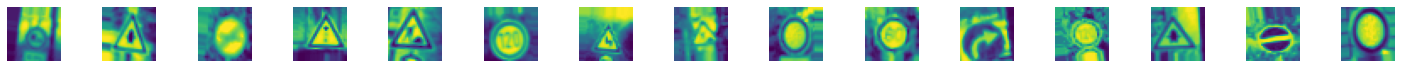

In [17]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

In [18]:
#One-hot Encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [19]:
def create_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [20]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
steps_per_epoch = len(X_train)//50

validation_steps = len(X_val)//50

print(steps_per_epoch)
print(validation_steps)

695
88


In [22]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=696, epochs=12, validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


696/696 [==============================] - 26s 19ms/step - loss: 1.8230 - accuracy: 0.4842 - val_loss: 0.3263 - val_accuracy: 0.8984
Epoch 2/12
696/696 [==============================] - 13s 18ms/step - loss: 0.6624 - accuracy: 0.7972 - val_loss: 0.2159 - val_accuracy: 0.9270
Epoch 3/12
696/696 [==============================] - 13s 19ms/step - loss: 0.4193 - accuracy: 0.8705 - val_loss: 0.1475 - val_accuracy: 0.9533
Epoch 4/12
696/696 [==============================] - 13s 18ms/step - loss: 0.3184 - accuracy: 0.9020 - val_loss: 0.0638 - val_accuracy: 0.9803
Epoch 5/12
696/696 [==============================] - 13s 18ms/step - loss: 0.2599 - accuracy: 0.9192 - val_loss: 0.0623 - val_accuracy: 0.9807
Epoch 6/12
696/696 [==============================] - 12s 18ms/step - loss: 0.2151 - accuracy: 0.9334 - val_loss: 0.0539 - val_accuracy: 0.9832
Epoch 7/12
696/696 [==============================] - 13s 18ms/step - loss: 0.1931 - accuracy: 0.9386 - val_loss: 0.0479 - val_accuracy: 0.9839
Epo

Text(0.5, 0, 'epoch')

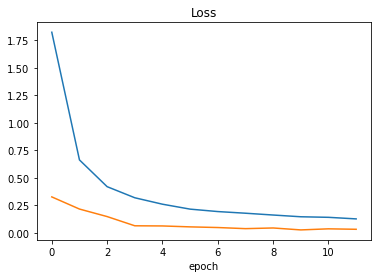

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

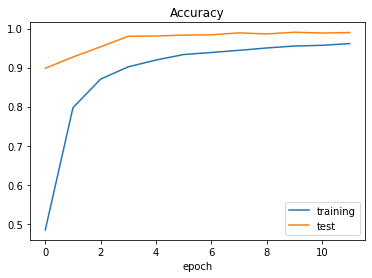

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

score = model.evaluate(X_test, y_test, verbose=0)

Test score: 0.12060774117708206
Test accuracy: 0.9665083289146423

predicted sign: Slippery road


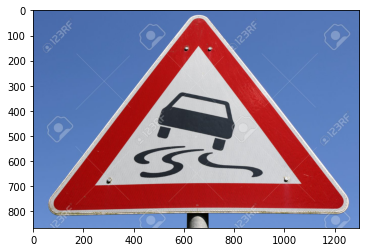

(1, 32, 32, 1)
predicted sign: Speed limit (30km/h)


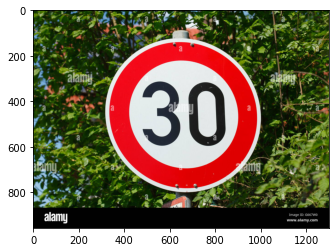

(1, 32, 32, 1)
predicted sign: Turn left ahead


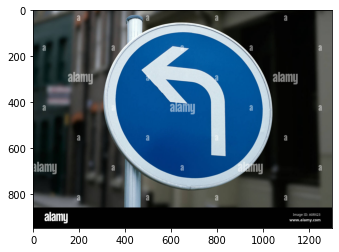

(1, 32, 32, 1)
predicted sign: Yield


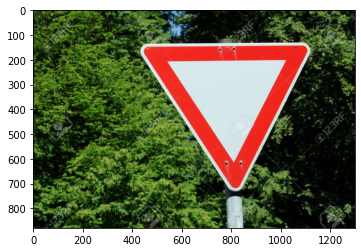

(1, 32, 32, 1)
predicted sign: Bicycles crossing


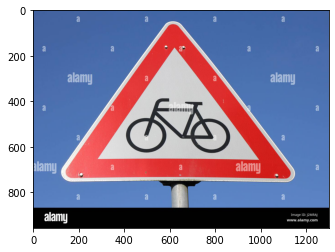

(1, 32, 32, 1)
predicted sign: Traffic signals


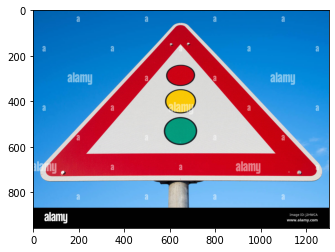

(1, 32, 32, 1)
predicted sign: Priority road


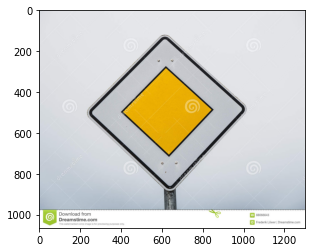

(1, 32, 32, 1)


In [28]:
print('Test score:', score[0])
print('Test accuracy:', score[1])
print()
 
import requests
from PIL import Image
url_list = []
url_slip = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
url_list.append(url_slip)
url_30 = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
url_list.append(url_30)
url_left = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url_list.append(url_left)
url_giveway='https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
url_list.append(url_giveway)
url_bicycle='https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
url_list.append(url_bicycle)
url_ex='https://c8.alamy.com/comp/J2HWCA/german-road-sign-traffic-signals-J2HWCA.jpg'
url_list.append(url_ex)
url_list.append('https://thumbs.dreamstime.com/z/german-priority-road-sign-yellow-white-88066643.jpg')

for new_url in url_list:
  r = requests.get(new_url, stream=True)
  img = Image.open(r.raw)
  plt.imshow(img, cmap=plt.get_cmap('gray'))
 
  img = np.asarray(img)
  img_or=img
  img = cv2.resize(img, (32, 32))
  img = preprocess(img)
  img = img.reshape(1, 32, 32, 1)
  print("predicted sign: "+ str(data['SignName'][np.argmax(model.predict(img), axis=-1)[0]]))
  plt.imshow(img_or, cmap = plt.get_cmap('gray'))
  plt.show()
  print(img.shape)
  
 
  